In [3]:
import openturns as ot
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from shapley import ShapleyIndices, ShapleyKrigingIndices, SobolIndices, SobolKrigingIndices
from shapley.tests import Ishigami, AdditiveGaussian
from shapley.tests.utils import true_gaussian_full_ind_sobol
from shapley.plots import set_style_paper, plot_sensitivity_results
from shapley.plots import plot_error, plot_var

%load_ext autoreload
%autoreload 2

%matplotlib inline

set_style_paper()

savefigs = True
ylim = [0, 1.0]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
dim = 3
beta = None
model = AdditiveGaussian(dim=dim, beta=beta)
model.margins = [ot.Normal()]*(dim-1) + [ot.Normal(0, 2.)]

corr = 0.
theta = [0., 0., corr]
model.copula_parameters = theta

true_results = {
    'Shapley': model.shapley_indices,
    'First Sobol': model.first_order_sobol_indices,
    'Total Sobol': model.total_sobol_indices
}

In [15]:
Nv = 5000

n_No = 15
n_Ni = 3

min_Ni = 1
max_Ni = 100
min_No = 1
max_No = 100

n_boot = 1000
n_run = 50

all_Ni = [2, 5, 10]
all_No = np.linspace(min_No, max_No, n_No, dtype=int)

In [16]:
ot.RandomGenerator.SetSeed(1)
np.random.seed(1)

all_shapley_results = np.zeros((n_No, n_Ni, n_run, dim, n_boot))
all_first_results = np.zeros((n_No, n_Ni, n_run, dim, n_boot))
all_total_results = np.zeros((n_No, n_Ni, n_run, dim, n_boot))

for i_No, No in enumerate(all_No):
    for i_Ni, Ni in enumerate(all_Ni):
        print('No:', No, 'Ni:', Ni)
        for i_run in range(n_run):
            shapley = ShapleyIndices(model.input_distribution)
            shapley.build_mc_sample(model=model, n_perms=None, Nv=Nv, No=No, Ni=Ni)
            shapley_results = shapley.compute_indices(n_boot=n_boot)
            all_shapley_results[i_No, i_Ni, i_run] = shapley_results.full_shapley_indices
            all_first_results[i_No, i_Ni, i_run] = shapley_results.full_first_indices
            all_total_results[i_No, i_Ni, i_run] = shapley_results.full_total_indices

No: 1 Ni: 2
No: 1 Ni: 5
No: 1 Ni: 10
No: 8 Ni: 2
No: 8 Ni: 5
No: 8 Ni: 10
No: 15 Ni: 2
No: 15 Ni: 5
No: 15 Ni: 10
No: 22 Ni: 2
No: 22 Ni: 5
No: 22 Ni: 10
No: 29 Ni: 2
No: 29 Ni: 5
No: 29 Ni: 10
No: 36 Ni: 2
No: 36 Ni: 5
No: 36 Ni: 10
No: 43 Ni: 2
No: 43 Ni: 5
No: 43 Ni: 10
No: 50 Ni: 2
No: 50 Ni: 5
No: 50 Ni: 10
No: 57 Ni: 2
No: 57 Ni: 5
No: 57 Ni: 10
No: 64 Ni: 2
No: 64 Ni: 5
No: 64 Ni: 10
No: 71 Ni: 2
No: 71 Ni: 5
No: 71 Ni: 10
No: 78 Ni: 2
No: 78 Ni: 5
No: 78 Ni: 10
No: 85 Ni: 2
No: 85 Ni: 5
No: 85 Ni: 10
No: 92 Ni: 2
No: 92 Ni: 5
No: 92 Ni: 10
No: 100 Ni: 2
No: 100 Ni: 5
No: 100 Ni: 10


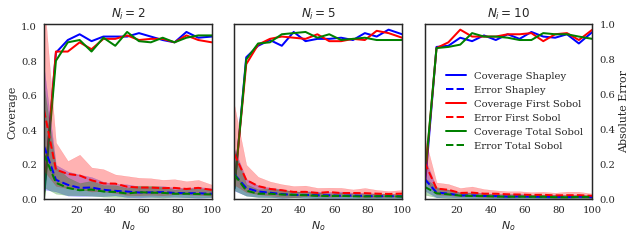

In [22]:
alpha = [2.75, 97.5]
legend = False
name = 'N_o'

if name == 'N_i':
    x = all_Ni
    x_c = all_No
    name_c = 'N_o'
    axis = 0
else:
    x = all_No
    x_c = all_Ni
    name_c = 'N_i'
    axis = 1

n = len(x_c)
if n > 3:
    assert n == 6, "Only works with n=6"
    fig, axes = plt.subplots(2, int(n/2), figsize=(2*3+3, 6), sharex=True, sharey=True)
    lvl = 2
else:
    fig, axes = plt.subplots(1, n, figsize=(2*n+3, 3.5), sharex=True, sharey=True) 
    lvl = 1
    
for i, (N, ax) in enumerate(zip(x_c, axes.ravel())):
    results = {
        'Shapley': all_shapley_results.take(i, axis=axis),
        'First Sobol': all_first_results.take(i, axis=axis),
        'Total Sobol': all_total_results.take(i, axis=axis)
    }
    if i == n-1:
        legend = True
        
    ax, ax2 = plot_error(results, x, true_results, ax=ax, ylim=[0., None], alpha=alpha, loc=5, logscale=False, legend=legend)
    
    if lvl == 1:
        ax.set_xlabel('$%s$' % (name))
        if i < n-1:
            ax2.set_ylabel('')
            ax2.set_yticks([])
        if i > 0:
            ax.set_ylabel('')
    else:
        if i != 2 and i != n-1:
            ax2.set_ylabel('')
        if i != 0 and i != 3:
            ax.set_ylabel('')
        if 2 < i <= n-1:
            ax.set_xlabel('$%s$' % (name))
        else:
            ax.set_xlabel('')            
        
    ax.set_title('$%s = %d$' % (name_c, N))
    
fig.tight_layout()
if savefigs:
    fig.savefig('./output/gaussian_precision_nNo_%d_nNi_%d_rho_%.2f_Nv_%d_maxNo_%d_maxNi_%d_nrun%d.pdf' % (n_No, n_Ni, corr, Nv, max_No, max_Ni, n_run))

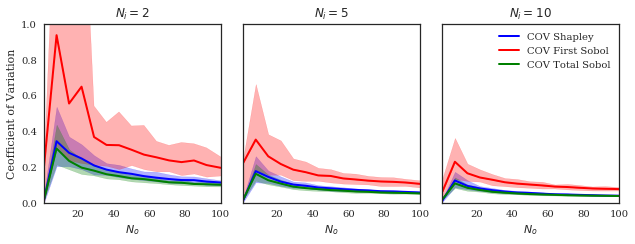

In [18]:
legend = False
if n > 3:
    assert n == 6, "Only works with n=6"
    fig, axes = plt.subplots(2, int(n/2), figsize=(2*3+3, 6), sharex=True, sharey=True)
    lvl = 2
else:
    fig, axes = plt.subplots(1, n, figsize=(2*n+3, 3.5), sharex=True, sharey=True) 
    lvl = 1
    
for i, (N, ax) in enumerate(zip(x_c, axes.ravel())):
    results = {
        'Shapley': all_shapley_results.take(i, axis=axis),
        'First Sobol': all_first_results.take(i, axis=axis),
        'Total Sobol': all_total_results.take(i, axis=axis)
    }
    if i == n-1:
        legend = True
        
    ax = plot_var(results, x, ax=ax, ylim=[0, 1], alpha=alpha, loc=0, logscale=False, legend=legend)
    
    if lvl == 1:
        ax.set_xlabel('$%s$' % (name))
        if i > 0:
            ax.set_ylabel('')
    else:
        if i != 0 and i != 3:
            ax.set_ylabel('')
        if 2 < i <= n-1:
            ax.set_xlabel('$%s$' % (name))
        else:
            ax.set_xlabel('')  
    
    fig.tight_layout()
    ax.set_title('$%s = %d$' % (name_c, N))
    if savefigs:
        fig.savefig('./output/var_gaussian_precision_nNo_%d_rho_%.2f_Nv_%d_maxNo_%d_maxNi_%d_nrun%d.pdf' % (n_No, corr, Nv, max_No, max_Ni, n_run))